##  Testing Assumptions
1. State assumptions
2. Check assumptions (with figures)
    1. residuals
    2. correlations
    3. \# of modes
 
### Step 1: State assumptions
$F_{X|0} = ER(p_0) = Bern(p_0)^{V \times V}$ <br/>
$F_{X|1} = ER(p_1) = Bern(p_1)^{V \times V}$

$p_1 \neq p_2$

### Step 2: Check assumptions


### Setup Step

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import igraph as ig

from sklearn import cross_validation
from sklearn.cross_validation import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

%matplotlib inline

np.random.seed(12345678)  # for reproducibility, set random seed
r = 20  # define number of rois
N = 100 # number of samples at each iteration
p0 = 0.10
p1 = 0.15
# define number of subjects per class
S = np.array((8, 16, 20, 32, 40, 64, 80, 100, 120, 200, 320,
              400, 800, 1000))

names = ["Nearest Neighbors", "Linear SVM", "Random Forest",
         "Linear Discriminant Analysis", "Quadratic Discriminant Analysis"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

###  Steps 4 & 5:  Sample data from setting similar to data and record classification accuracy

In [2]:
accuracy = np.zeros((len(S), len(classifiers), 2), dtype=np.dtype('float64'))
for idx1, s in enumerate(S):
    s0=s/2
    s1=s/2

    g0 = 1 * (np.random.rand( r, r, s0) > 1-p0)
    g1 = 1 * (np.random.rand( r, r, s1) > 1-p1)
    mbar0 = 1.0*np.sum(g0, axis=(0,1))
    mbar1 = 1.0*np.sum(g1, axis=(0,1))

    X = np.array((np.append(mbar0, mbar1), np.append(mbar0/( r**2), mbar1/( r**2 )))).T
    y = np.append(np.zeros(s0), np.ones(s1))
    
    for idx2, cla in enumerate(classifiers):
        X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.4, random_state=0)
        clf = cla.fit(X_train, y_train)
        loo = LeaveOneOut(len(X))
        scores = cross_validation.cross_val_score(clf, X, y, cv=loo)
        accuracy[idx1, idx2,] = [scores.mean(), scores.std()]
        print("Accuracy of %s: %0.2f (+/- %0.2f)" % (names[idx2], scores.mean(), scores.std() * 2))
    
print accuracy

Accuracy of Nearest Neighbors: 1.00 (+/- 0.00)
Accuracy of Linear SVM: 1.00 (+/- 0.00)
Accuracy of Random Forest: 1.00 (+/- 0.00)
Accuracy of Linear Discriminant Analysis: 1.00 (+/- 0.00)
Accuracy of Quadratic Discriminant Analysis: 0.50 (+/- 1.00)
Accuracy of Nearest Neighbors: 0.88 (+/- 0.66)
Accuracy of Linear SVM: 0.94 (+/- 0.48)
Accuracy of Random Forest: 0.94 (+/- 0.48)
Accuracy of Linear Discriminant Analysis: 0.94 (+/- 0.48)
Accuracy of Quadratic Discriminant Analysis: 0.88 (+/- 0.66)
Accuracy of Nearest Neighbors: 1.00 (+/- 0.00)
Accuracy of Linear SVM: 1.00 (+/- 0.00)
Accuracy of Random Forest: 0.95 (+/- 0.44)
Accuracy of Linear Discriminant Analysis: 1.00 (+/- 0.00)
Accuracy of Quadratic Discriminant Analysis: 0.95 (+/- 0.44)
Accuracy of Nearest Neighbors: 0.97 (+/- 0.35)
Accuracy of Linear SVM: 0.97 (+/- 0.35)
Accuracy of Random Forest: 0.97 (+/- 0.35)
Accuracy of Linear Discriminant Analysis: 0.97 (+/- 0.35)
Accuracy of Quadratic Discriminant Analysis: 0.97 (+/- 0.35)
Accu

/usr/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:712: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:715: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])


### Step 6: Plot Accuracy versus N

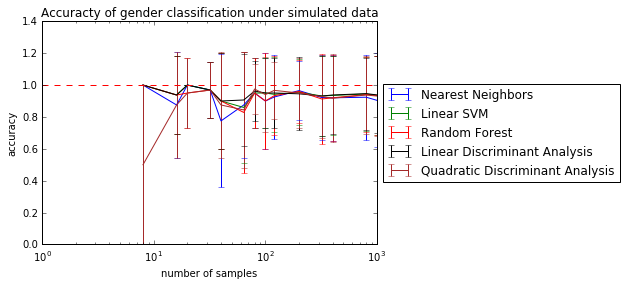

In [3]:
plt.errorbar(S, accuracy[:,0,0], yerr = accuracy[:,0,1], hold=True, label=names[0])
plt.errorbar(S, accuracy[:,1,0], yerr = accuracy[:,1,1], color='green', hold=True, label=names[1])
plt.errorbar(S, accuracy[:,2,0], yerr = accuracy[:,2,1], color='red', hold=True, label=names[2])
plt.errorbar(S, accuracy[:,3,0], yerr = accuracy[:,3,1], color='black', hold=True, label=names[3])
plt.errorbar(S, accuracy[:,4,0], yerr = accuracy[:,4,1], color='brown', hold=True, label=names[4])
plt.xscale('log')
plt.xlabel('number of samples')
plt.ylabel('accuracy')
plt.title('Accuracty of gender classification under simulated data')
plt.axhline(1, color='red', linestyle='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Step 7: Apply technique to data

In [4]:
# Initializing dataset names
dnames = list(['../data/KKI2009'])
print "Dataset: " + ", ".join(dnames)

# Getting graph names
fs = list()
for dd in dnames:
        fs.extend([root+'/'+file for root, dir, files in os.walk(dd) for file in files])
fs = fs[1:]
def loadGraphs(filenames, rois, printer=False):
    A = np.zeros((rois, rois, len(filenames)))
    for idx, files in enumerate(filenames):
        if printer:
            print "Loading: " + files
        g = ig.Graph.Read_GraphML(files)
        tempg = g.get_adjacency(attribute='weight')
        A[:,:,idx] = np.asarray(tempg.data)
        
    return A

# Load X
X = loadGraphs(fs, 70)
print X.shape

# Load Y
ys = csv.reader(open('../data/kki42_subjectinformation.csv'))
y = [y[5] for y in ys]
y = [1 if x=='F' else 0 for x in y[1:]]

xf = 1.0*np.sum(1.0*(X>0), axis=(0,1))
features = np.array((xf, xf/( 70**2 * 22))).T

Dataset: ../data/KKI2009
(70, 70, 42)


In [5]:
accuracy=np.zeros((len(classifiers),2))
X_train, X_test, y_train, y_test = cross_validation.train_test_split(features, y, test_size=0.4, random_state=0)
for idx, cla in enumerate(classifiers):
    clf = cla.fit(X_train, y_train)
    loo = LeaveOneOut(len(features))
    scores = cross_validation.cross_val_score(clf, features, y, cv=loo)
    accuracy[idx,] = [scores.mean(), scores.std()]
    print("Accuracy of %s: %0.2f (+/- %0.2f)" % (names[idx], scores.mean(), scores.std() * 2))

Accuracy of Nearest Neighbors: 0.48 (+/- 1.00)
Accuracy of Linear SVM: 0.55 (+/- 1.00)
Accuracy of Random Forest: 0.57 (+/- 0.99)
Accuracy of Linear Discriminant Analysis: 0.45 (+/- 1.00)
Accuracy of Quadratic Discriminant Analysis: 0.71 (+/- 0.90)


### Step 8: Reflect on result

The classification accuracy on real data based on the five tested classifiers is, at best, 71%, and worst, chance. I am not surprised at this result, as the features computed on the graphs, edge count and edge probability (which are linearly related) are very basic. I am suspicious that the QDA method performed as well as it did, while others all had similar performance to one another.